In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:0000:0100:02
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for py4j==0.10.9.7 from https://files.pythonhosted.org/packages/10/30/a58b32568f1623aaad7db22aa9eafc4c6c194b429ff35bdc55ca2726da47/py4j-0.10.9.7-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 3.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488496 sha256=2b7c38a38ec127903d554ca29b6ad93dd470d0a6e584bd4a512dc06a6c3d3464
  Stored in directory: /Users/minami/Library/Caches/pip/wheels/95/13/41/f7f135ee114175605fb4f0a89e7389f3742aa6c1e1a5bcb657
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification  import LogisticRegression
from pyspark.ml.feature import HashingTF,VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType, FloatType, IntegerType, LongType
from pyspark.sql.functions import col

# 创建SparkSession
spark = SparkSession.builder \
    .appName("PySpark MLlib Example") \
    .getOrCreate()

# 加载数据集
data = spark.read.csv("/Users/minami/Desktop/kimi/data mining/Mood_data_clean.csv", header=True, inferSchema=True)
# data = spark.read.csv("/Users/minami/Desktop/kimi/app/df_modcloth.csv", header=True, inferSchema=True)

# 数据预处理：创建特征向量
# 获取数据集的列和对应的数据类型


data = data.withColumnRenamed("circumplex.arousal", "circumplexarousal")
data = data.withColumnRenamed("circumplex.valence", "circumplexvalence")
data = data.withColumnRenamed("appCat.builtin", "appCatbuiltin")
data = data.withColumnRenamed("appCat.communication", "appCatcommunication")
data = data.withColumnRenamed("appCat.finance", "appCatfinance")
data = data.withColumnRenamed("appCat.other", "appCatother")
data = data.withColumnRenamed("appCat.social", "appCatsocial")
data = data.withColumnRenamed("appCat.travel", "appCattravel")
data = data.withColumnRenamed("appCat.unknown", "appCatunknown")
data = data.withColumnRenamed("appCat.utilities", "appCatutilities")
data = data.withColumnRenamed("appCat.weather", "appCatweather")
data = data.withColumnRenamed("appCat.entertainment", "appCatentertainment")
data = data.withColumnRenamed("appCat.game", "appCatgame")
data = data.withColumnRenamed("appCat.office", "appCatoffice")

data = data.withColumn("mood (target)", col("mood (target)").cast(DoubleType()))

data = data.dropna()

columns = data.schema.names
data_types = [field.dataType for field in data.schema.fields]
numeric_columns = [columns[i] for i, dtype in enumerate(data_types) if isinstance(dtype, (DoubleType, FloatType, IntegerType, LongType))]



print("数值型列:", numeric_columns)

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
data = assembler.transform(data)

# 划分数据集为训练集和测试集
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

# 使用逻辑回归模型进行训练
lr = LogisticRegression(labelCol="mood (target)", featuresCol="features")
model = lr.fit(train_data)

# 在测试集上进行预测
predictions = model.transform(test_data)

# 评估模型性能
evaluator = RegressionEvaluator(labelCol="mood (target)", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("模型均方根误差 (RMSE):", rmse)

# 关闭SparkSession
spark.stop()

In [3]:
data.head(10)

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0
5,6,AS14.01,2014-02-27 12:00:00.000,mood,6.0
6,7,AS14.01,2014-02-27 15:00:00.000,mood,7.0
7,8,AS14.01,2014-03-21 09:00:00.000,mood,6.0
8,9,AS14.01,2014-03-21 11:00:00.000,mood,6.0
9,10,AS14.01,2014-03-21 15:00:00.000,mood,7.0


In [18]:
import pandas as pd
df = pd.read_csv('dataset_mood_smartphone.csv')

# df.drop_duplicates(subset=['id', 'variable', 'time'], keep='first', inplace=True)




unique_values = df.iloc[:, -2].unique()
result_df = pd.DataFrame()
for value in unique_values:
    # 筛选出倒数第二列等于当前唯一值的行
    filtered_rows = df[df.iloc[:, -2] == value]
    # 获取倒数第一列的值
    last_column_values = filtered_rows.iloc[:, -1].fillna('1').values
    # 将倒数第一列的值作为新列，列名为当前唯一值
    result_df[value] = last_column_values

result_df.to_csv('output_file.csv', index=False)


# # 读取 CSV 文件
# df = pd.read_csv("dataset_mood_smartphone.csv", header=None)

# # 获取倒数第二列作为列名
# column_names = df.iloc[:, -2].tolist()

# # 获取倒数第一列作为列值
# column_values = df.iloc[:, -1].tolist()

# # 创建 DataFrame
# data = {column_names[-1]: column_values}
# df_final = pd.DataFrame(data)

# # 保存到新的 CSV 文件
# df_final.to_csv("output_file.csv", index=False)


# import pandas as pd

# # 1. 读取 CSV 文件并加载数据
# data = pd.read_csv("dataset_mood_smartphone.csv")

# # 2. 根据 ID 分组并执行合并操作
# grouped_data = data.groupby('id').agg(lambda x: ','.join(x.unique()))

# # 3. 将处理后的数据写回到 CSV 文件中
# grouped_data.to_csv("output.csv")


# # 读取CSV文件
# df = pd.read_csv('dataset_mood_smartphone.csv')

# # 根据'id'列合并行，保留之前未出现的列名和列，并且重复的列只保留一个
# merged_df = df.groupby('id', as_index=False).first()

# # 保存合并后的数据到新的CSV文件
# merged_df.to_csv('merged_file.csv', index=False)


ValueError: Length of values (22965) does not match length of index (5628)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
from sklearn.model_selection import train_test_split

for dirname, _, filenames in os.walk('../data mining/Sunspots.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv("../data mining/Sunspots.csv")
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.7+ KB


In [5]:
from dateutil.parser import parse
dateparse=lambda dates:parse(dates)

In [7]:
df = pd.read_csv('../data mining/Sunspots.csv',usecols=['Date','Monthly Mean Total Sunspot Number'],parse_dates=['Date'],date_parser=dateparse)
df.head()

/var/folders/g6/tqykz2q510j48yls1qryzrkw0000gn/T/ipykernel_802/684574774.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('../data mining/Sunspots.csv',usecols=['Date','Monthly Mean Total Sunspot Number'],parse_dates=['Date'],date_parser=dateparse)


,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               3265 non-null   datetime64[ns]
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.1 KB


In [10]:
df_non_index=df.copy()

In [11]:
df_non_index['Month']=df_non_index.Date.dt.month
df_non_index.head()

,Date,Monthly Mean Total Sunspot Number,Month
0,1749-01-31,96.7,1
1,1749-02-28,104.3,2
2,1749-03-31,116.7,3
3,1749-04-30,92.8,4
4,1749-05-31,141.7,5


In [12]:
df_non_index['nth_year'] =[int(str(i)[3]) for i in (df_non_index.Date.dt.year)] # Note this is list comprehension 
df_non_index['nth_year'].replace(0,10,inplace=True)
df_non_index.head(10)

,Date,Monthly Mean Total Sunspot Number,Month,nth_year
0,1749-01-31,96.7,1,9
1,1749-02-28,104.3,2,9
2,1749-03-31,116.7,3,9
3,1749-04-30,92.8,4,9
4,1749-05-31,141.7,5,9
5,1749-06-30,139.2,6,9
6,1749-07-31,158.0,7,9
7,1749-08-31,110.5,8,9
8,1749-09-30,126.5,9,9
9,1749-10-31,125.8,10,9


Mean Squared Error (MSE): 4272.596487882795
Root Mean Squared Error (RMSE): 65.36510145240192
Mean Absolute Error (MAE): 54.016762422683335


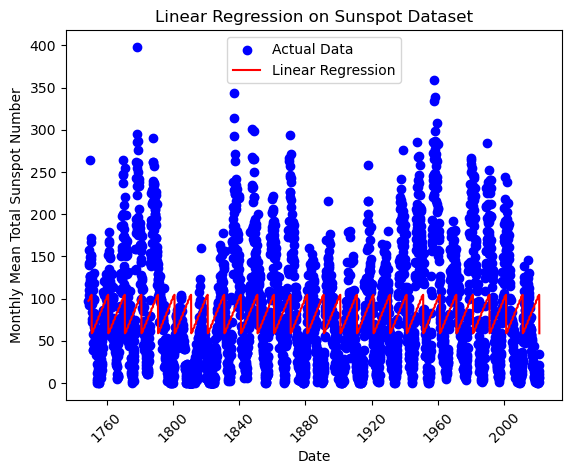

In [27]:
model = LinearRegression()



X = df_non_index[['Month', 'nth_year']]
y = df_non_index['Monthly Mean Total Sunspot Number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# 进行预测
y_pred_test = model.predict(X_test)
# 计算均方误差（MSE）
mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error (MSE):", mse)

# 计算均方根误差（RMSE）
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

# 绘制结果
plt.scatter(df_non_index['Date'], df_non_index['Monthly Mean Total Sunspot Number'], color='blue', label='Actual Data')
plt.plot(df_non_index['Date'], y_pred, color='red', label='Linear Regression')
plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Linear Regression on Sunspot Dataset')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.15.0


In [2]:
df_sun = pd.read_csv('../data mining/Sunspots.csv')

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    if not isinstance(series, pd.Series):
        series = pd.Series(series, index=time)
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

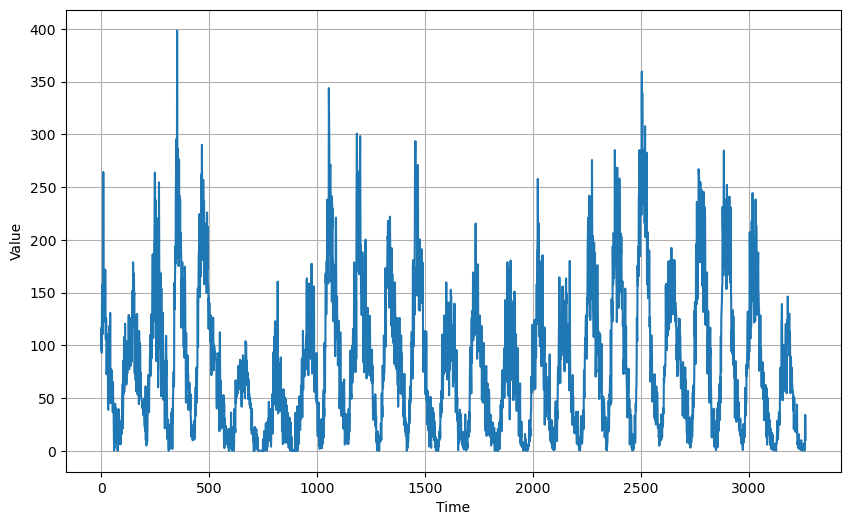

In [16]:
series = df_sun['Monthly Mean Total Sunspot Number']
time = df_sun['Unnamed: 0']

plt.figure(figsize=(10, 6))
plot_series(time, series)

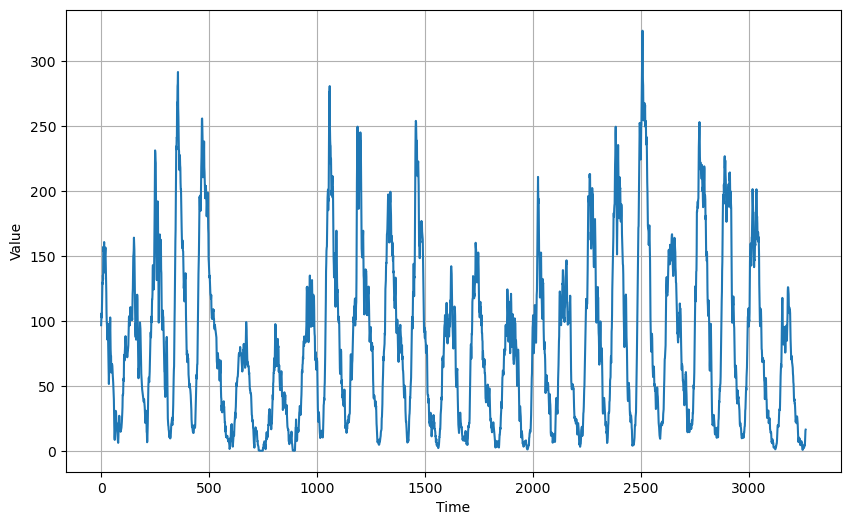

In [27]:
# 定义简单移动平均函数
def simple_moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

# 对原始数据进行简单移动平均降噪
window_size = 5
series_smooth = simple_moving_average(series, window_size)

# 绘制降噪后的数据
plt.figure(figsize=(10, 6))
plot_series(time, series_smooth)


In [42]:
split_time = 2500
time_train = time[:split_time]
x_train = series_smooth[:split_time]
time_valid = time[split_time:]
x_valid = series_smooth[split_time:]

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


In [44]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=7e-6, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=20)

Epoch 1/20
39/39 [==============================] - 2s 27ms/step - loss: 31.1986 - mae: 31.6932
Epoch 2/20
39/39 [==============================] - 1s 27ms/step - loss: 15.9629 - mae: 16.4533
Epoch 3/20
39/39 [==============================] - 1s 28ms/step - loss: 12.2833 - mae: 12.7712
Epoch 4/20
39/39 [==============================] - 1s 28ms/step - loss: 11.7768 - mae: 12.2647
Epoch 5/20
39/39 [==============================] - 1s 28ms/step - loss: 9.6515 - mae: 10.1365
Epoch 6/20
39/39 [==============================] - 1s 28ms/step - loss: 9.2035 - mae: 9.6880
Epoch 7/20
39/39 [==============================] - 1s 28ms/step - loss: 9.4382 - mae: 9.9229
Epoch 8/20
39/39 [==============================] - 1s 28ms/step - loss: 10.5275 - mae: 11.0140
Epoch 9/20
39/39 [==============================] - 1s 28ms/step - loss: 11.0650 - mae: 11.5528
Epoch 10/20
39/39 [==============================] - 1s 28ms/step - loss: 7.9243 - mae: 8.4064
Epoch 11/20
39/39 [===========================

101/101 [==============================] - 1s 5ms/step

MAE: 7.077435


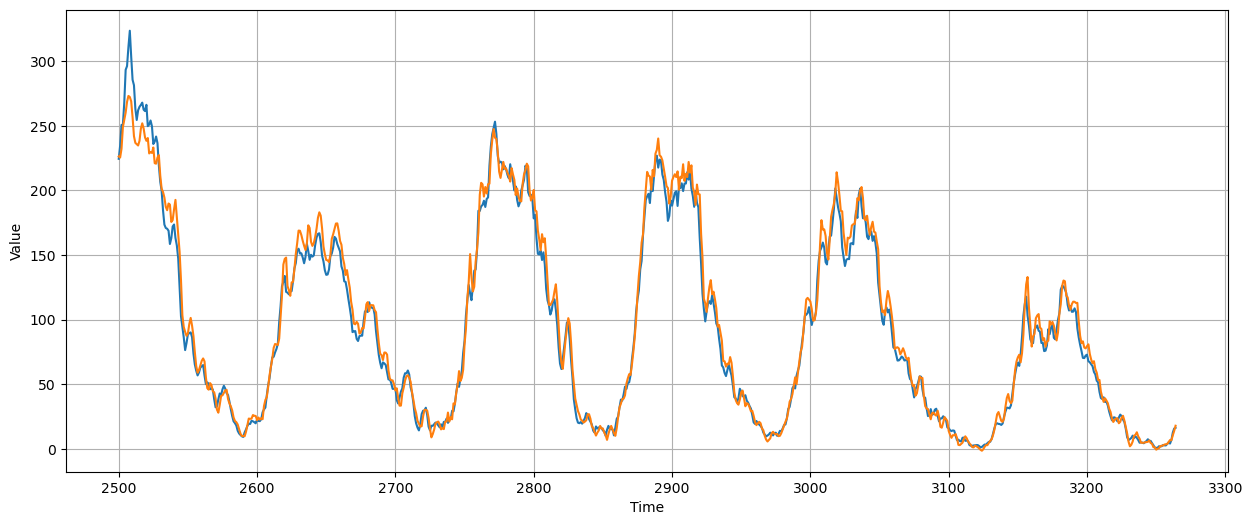

In [45]:

# 将 series 转换为 NumPy 数组
series_np = np.array(series_smooth)

# 使用训练好的模型对数据进行预测
rnn_forecast = model_forecast(model, series_np[..., np.newaxis], window_size)

# 对预测结果进行处理
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# 计算 MAE
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
print('\nMAE:', mae)

# 绘制真实值和预测值的对比图
plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [38]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=7e-6, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=20)

Epoch 1/20
39/39 [==============================] - 2s 27ms/step - loss: 36.3544 - mae: 36.8505
Epoch 2/20
39/39 [==============================] - 1s 27ms/step - loss: 23.7487 - mae: 24.2431
Epoch 3/20
39/39 [==============================] - 1s 28ms/step - loss: 20.8967 - mae: 21.3900
Epoch 4/20
39/39 [==============================] - 1s 30ms/step - loss: 19.7203 - mae: 20.2128
Epoch 5/20
39/39 [==============================] - 1s 29ms/step - loss: 19.3143 - mae: 19.8067
Epoch 6/20
39/39 [==============================] - 1s 29ms/step - loss: 19.0021 - mae: 19.4945
Epoch 7/20
39/39 [==============================] - 1s 29ms/step - loss: 18.7040 - mae: 19.1962
Epoch 8/20
39/39 [==============================] - 1s 29ms/step - loss: 18.4405 - mae: 18.9327
Epoch 9/20
39/39 [==============================] - 1s 29ms/step - loss: 17.9689 - mae: 18.4610
Epoch 10/20
39/39 [==============================] - 1s 29ms/step - loss: 17.9988 - mae: 18.4907
Epoch 11/20
39/39 [====================

101/101 [==============================] - 1s 5ms/step

MAE: 21.53428


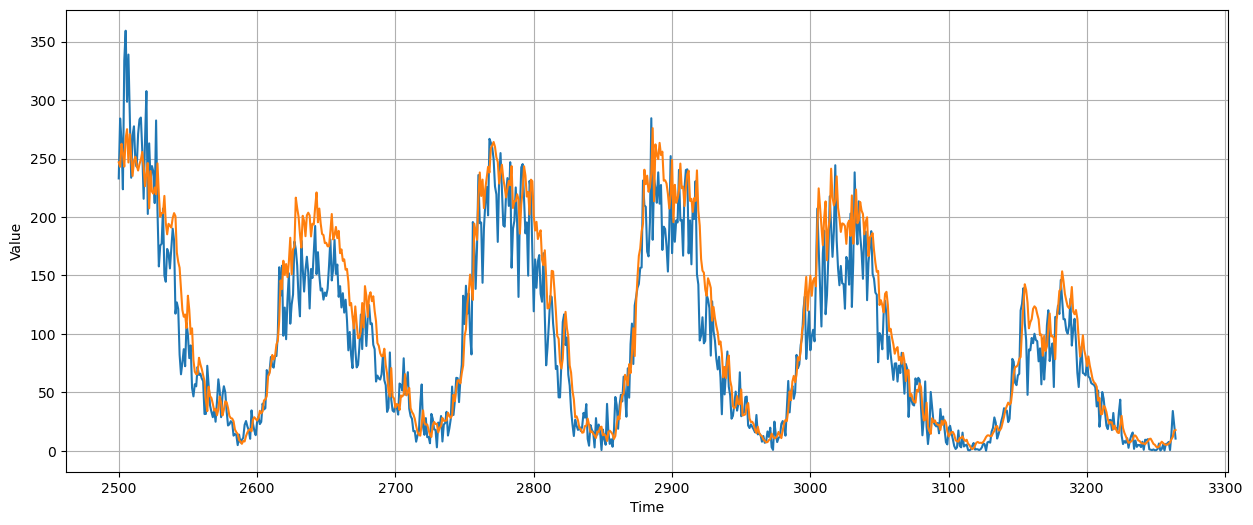

In [39]:

# 将 series 转换为 NumPy 数组
series_np = np.array(series)

# 使用训练好的模型对数据进行预测
rnn_forecast = model_forecast(model, series_np[..., np.newaxis], window_size)

# 对预测结果进行处理
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# 计算 MAE
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
print('\nMAE:', mae)

# 绘制真实值和预测值的对比图
plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [48]:
split_time = 2500
time_train3 = time[:split_time]
x_train3 = series[:split_time]
time_valid3 = time[split_time:]
x_valid3 = series[split_time:]

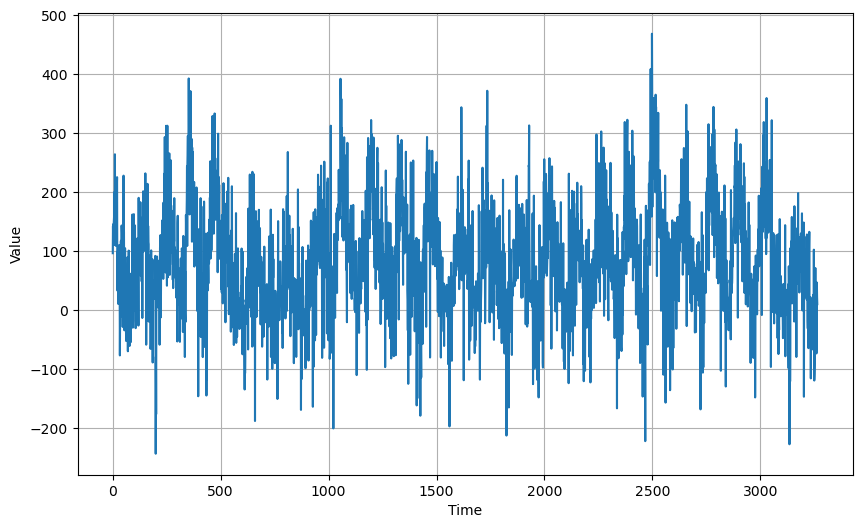

In [52]:
def add_noise(df, column, mean=0):
    mc_data = df.copy(deep=True)
    stddev = np.std(mc_data[column])
    sampled_rows = mc_data.sample(frac=0.3)
    noise = np.random.normal(mean, stddev, size=len(sampled_rows))
    df.loc[sampled_rows.index, column] += noise

# 添加噪声
add_noise(df_sun,'Monthly Mean Total Sunspot Number')
series3 = df_sun['Monthly Mean Total Sunspot Number']
time3 = df_sun['Unnamed: 0']
plt.figure(figsize=(10, 6))
plot_series(time3 , series3 )

In [53]:
split_time = 2500
time_before= time3[:split_time]
x_train_before = series3[:split_time]
time_valid_before = time3[split_time:]
x_valid_before = series3[split_time:]

In [54]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(x_train_before, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


In [55]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=7e-6, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=20)

Epoch 1/20
39/39 [==============================] - 2s 28ms/step - loss: 58.8599 - mae: 59.3577
Epoch 2/20
39/39 [==============================] - 1s 27ms/step - loss: 50.6635 - mae: 51.1604
Epoch 3/20
39/39 [==============================] - 1s 29ms/step - loss: 48.9861 - mae: 49.4825
Epoch 4/20
39/39 [==============================] - 1s 29ms/step - loss: 48.1761 - mae: 48.6728
Epoch 5/20
39/39 [==============================] - 1s 29ms/step - loss: 47.1135 - mae: 47.6098
Epoch 6/20
39/39 [==============================] - 1s 30ms/step - loss: 46.6987 - mae: 47.1951
Epoch 7/20
39/39 [==============================] - 1s 29ms/step - loss: 46.1376 - mae: 46.6335
Epoch 8/20
39/39 [==============================] - 1s 29ms/step - loss: 45.7691 - mae: 46.2651
Epoch 9/20
39/39 [==============================] - 1s 29ms/step - loss: 45.5400 - mae: 46.0358
Epoch 10/20
39/39 [==============================] - 1s 29ms/step - loss: 45.1079 - mae: 45.6036
Epoch 11/20
39/39 [====================

101/101 [==============================] - 1s 5ms/step

MAE: 46.603996


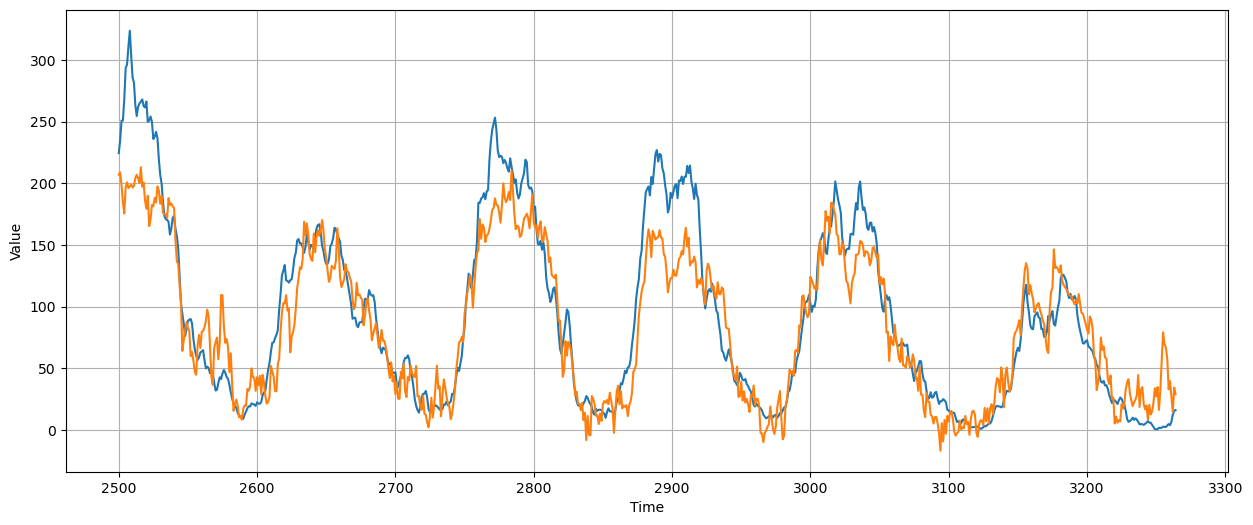

In [57]:

# 将 series 转换为 NumPy 数组
series_np = np.array(series3)

# 使用训练好的模型对数据进行预测
rnn_forecast = model_forecast(model, series_np[..., np.newaxis], window_size)

# 对预测结果进行处理
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# 计算 MAE
mae = tf.keras.metrics.mean_absolute_error(x_valid_before, rnn_forecast).numpy()
print('\nMAE:', mae)

# 绘制真实值和预测值的对比图
plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

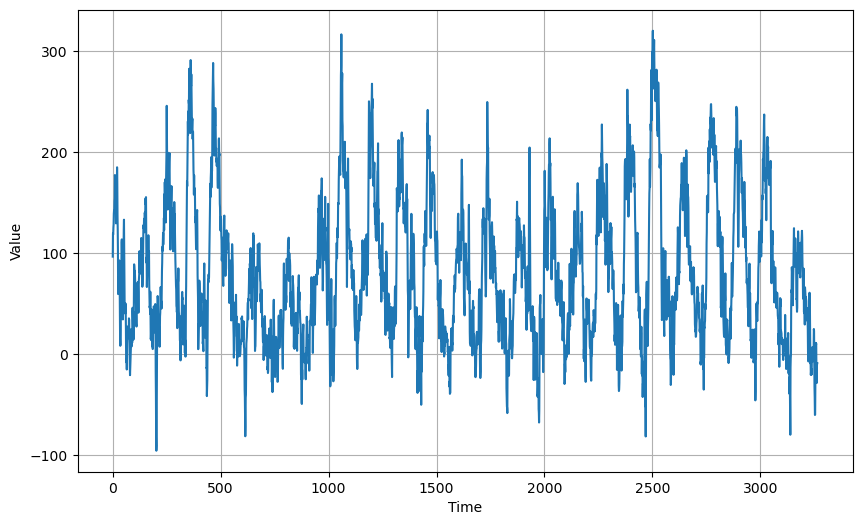

In [58]:
# 定义简单移动平均函数
def simple_moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

# 对原始数据进行简单移动平均降噪
window_size = 5
series_smoothed = simple_moving_average(series3, window_size)

# 绘制降噪后的数据
plt.figure(figsize=(10, 6))
plot_series(time3, series_smoothed)


In [59]:
split_time = 2500
time_train_smoothed = time3[:split_time]
x_train_smoothed = series_smoothed[:split_time]
time_valid_smoothed = time3[split_time:]
x_valid_smoothed = series_smoothed[split_time:]

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(x_train_smoothed , window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


In [61]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=7e-6, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=20)

Epoch 1/20
39/39 [==============================] - 2s 28ms/step - loss: 45.8510 - mae: 46.3484
Epoch 2/20
39/39 [==============================] - 1s 28ms/step - loss: 26.9980 - mae: 27.4935
Epoch 3/20
39/39 [==============================] - 1s 28ms/step - loss: 22.1529 - mae: 22.6475
Epoch 4/20
39/39 [==============================] - 1s 29ms/step - loss: 19.4513 - mae: 19.9452
Epoch 5/20
39/39 [==============================] - 1s 29ms/step - loss: 18.0545 - mae: 18.5479
Epoch 6/20
39/39 [==============================] - 1s 29ms/step - loss: 16.7820 - mae: 17.2751
Epoch 7/20
39/39 [==============================] - 1s 29ms/step - loss: 16.7761 - mae: 17.2691
Epoch 8/20
39/39 [==============================] - 1s 29ms/step - loss: 16.5305 - mae: 17.0233
Epoch 9/20
39/39 [==============================] - 1s 29ms/step - loss: 15.1582 - mae: 15.6501
Epoch 10/20
39/39 [==============================] - 1s 29ms/step - loss: 15.1018 - mae: 15.5938
Epoch 11/20
39/39 [====================

101/101 [==============================] - 1s 5ms/step

MAE: 13.970204


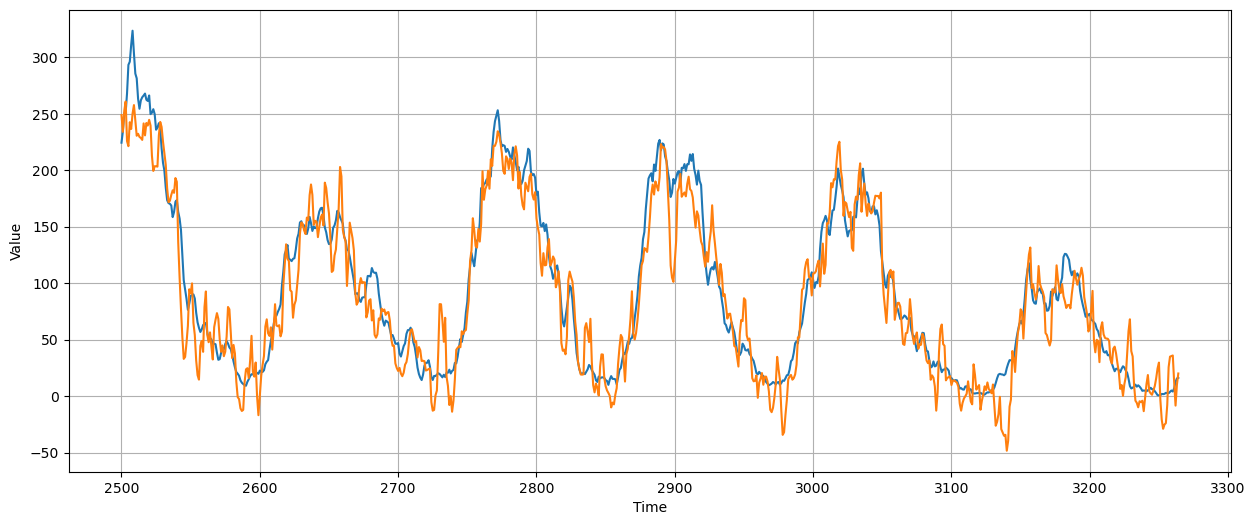

In [62]:

# 将 series 转换为 NumPy 数组
series_np = np.array( series_smoothed)

# 使用训练好的模型对数据进行预测
rnn_forecast = model_forecast(model, series_np[..., np.newaxis], window_size)

# 对预测结果进行处理
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# 计算 MAE
mae = tf.keras.metrics.mean_absolute_error(x_valid_smoothed, rnn_forecast).numpy()
print('\nMAE:', mae)

# 绘制真实值和预测值的对比图
plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()